In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import math

from skimage.draw import line

In [2]:
C1 = 0.60
C2 = 0.55
C3 = 0.15
N = 128


# 计算欧几里德距离
def dist(pointA, pointB):
    return math.sqrt((pointA['x'] - pointB['x']) ** 2 + (pointA['y'] - pointB['y']) ** 2)


# 求解在经过点 point 斜率为 x_slope 的直线上距离 pointL 的长度为 distance 的两个点的坐标
def find_point_on_line(point, slope, distance):
    intercept_x = distance / math.sqrt(1 + slope ** 2)
    intercept_y = distance / math.sqrt(1 + slope ** 2) * slope
    pointA = {'x': point['x'] - intercept_x, 'y': point['y'] - intercept_y}
    pointB = {'x': point['x'] + intercept_x, 'y': point['y'] + intercept_y}
    return pointA, pointB


# 获取手指间隙的坐标
def gap_point(image):
    # 得到二值图像
    blur_image = cv2.GaussianBlur(image, (5, 5), 0)
    _, binary_image = cv2.threshold(blur_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 计算质心
    mu = cv2.moments(binary_image)
    pointC = {'x': mu['m10'] // mu['m00'], 'y': mu['m01'] // mu['m00']}

    # 求轮廓, 并将轮廓重新排序, 使横纵坐标和最小的点排在最前面
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)  # 得到的 contours 是 tuple 类型
    areas = [cv2.contourArea(contour) for contour in contours]
    contours = contours[areas.index(max(areas))].reshape(-1, 2)  # 取最大的轮廓, 维度是 (n, 1, 2), reshape 维度为 (n, 2), n 代表轮廓中点的个数
    index = np.argmin(contours.sum(-1))
    contours = np.concatenate([contours[index:, :], contours[:index, :]])
    
    # 找到轮廓中距质心的距离变化的极值点
    distance = np.sqrt(np.square(contours - [pointC['x'], pointC['y']]).sum(-1))
    f = np.fft.rfft(distance)  # 傅立叶变换, 使距离变平滑
    f = np.concatenate([f[:15], 0 * f[15:]])  # 只要变化最剧烈的部分
    distance = np.fft.irfft(f)  # 傅立叶逆变换
    derivative = np.diff(distance)  # 一阶导
    sign_change = np.diff(np.sign(derivative)) / 2  # 二阶导, 即 (1 1 1 0 -1 -1 -1 0 1 1) 的导数
    points = contours[np.where(sign_change > 0)[0]]

    # 找到手指间隙
    points = points[np.argsort(points[:, 1])][:4]
    points = points[np.argsort(points[:, 0])]
    distances = np.zeros((4, 4))
    for i in range(4):
        for j in range(4):
            distances[i, j] = math.sqrt(np.square(points[i] - points[j]).sum(-1))
    distanceL = distances[0, 1] + distances[1, 2] + distances[0, 2]
    distanceR = distances[1, 2] + distances[2, 3] + distances[1, 3]
    if distanceL < distanceR:
        pointG1 = {'x': points[0][0], 'y': points[0][1]}
        pointG2 = {'x': points[2][0], 'y': points[2][1]}
    else:
        pointG1 = {'x': points[1][0], 'y': points[1][1]}
        pointG2 = {'x': points[3][0], 'y': points[3][1]}
    return contours, pointG1, pointG2


# 建立坐标系: 求解以 pointG1, pointG2 为 x 轴, 其垂直平分线为 y 轴的坐标系
def coordinate_system(pointG1, pointG2):
    origin = {'x': (pointG1['x'] + pointG2['x']) / 2, 'y': (pointG1['y'] + pointG2['y']) / 2}
    x_slope = (pointG1['y'] - pointG2['y']) / (pointG1['x'] - pointG2['x'])
    x_slope = 0.000001 if abs(x_slope) < 0.000001 else x_slope
    y_slope = -1 / x_slope
    pointT1, pointT2 = find_point_on_line(origin, y_slope, dist(pointG1, pointG2) * C1)
    pointL = pointT1 if pointT1['y'] > origin['y'] else pointT2
    return origin, x_slope, y_slope, pointL


# 获取手掌边缘的坐标: 求解经过点 pointL 斜率为 x_slope 的直线与手掌轮廓 contours 的交点
def edge_point(contours, pointL, x_slope, hand_type):
    x, _, w, _ = cv2.boundingRect(contours)  # 返回值是左上角的 x, y 坐标、矩形的宽和高
    line_start = {'x': x, 'y': round(x_slope * (x - pointL['x']) + pointL['y'])}
    line_end = {'x': x + w, 'y': round(x_slope * (x + w - pointL['x']) + pointL['y'])}
    points = []
    last = -1
    cnt = 0
    for point in zip(*line(line_start['x'], line_start['y'], line_end['x'], line_end['y'])):
        point = tuple([int(round(point[0])), int(round(point[1]))])
        now = cv2.pointPolygonTest(contours, point, False)
        if now == 0 or last * now < 0:
            if cnt == 0:
                points.append(point) 
                cnt += 1
            elif cnt > 0 and abs(points[cnt - 1][0] - point[0]) > 10:
                points.append(point) 
                cnt += 1
        last = now
    if hand_type == 'l':
        pointE1 = {'x': points[-2][0], 'y': points[-2][1]}
        pointE2 = {'x': points[-1][0], 'y': points[-1][1]}
    else:
        pointE1 = {'x': points[0][0], 'y': points[0][1]}
        pointE2 = {'x': points[1][0], 'y': points[1][1]}
    return pointE1, pointE2 


# 获取 ROI 顶点的坐标: 求解相对于 pointL, 处于特定位置的 ROI 的四个顶点的坐标
def roi_vertex(pointL, pointE1, pointE2, x_slope, y_slope):
    side = dist(pointE1, pointE2) * C2
    _, pointT1 = find_point_on_line(pointL, y_slope, dist(pointE1, pointE2) * C3)
    pointT1, pointT2 = find_point_on_line(pointL, y_slope, dist(pointE1, pointE2) * C3)
    pointS1 = pointT1 if pointT1['y'] < pointL['y'] else pointT2
    pointT1, pointT2 = find_point_on_line(pointL, y_slope, side - dist(pointE1, pointE2) * C3)
    pointS2 = pointT1 if pointT1['y'] > pointL['y'] else pointT2
    pointV1, pointV2 = find_point_on_line(pointS1, x_slope, side / 2)
    pointV3, pointV4 = find_point_on_line(pointS2, x_slope, side / 2)
    return pointV1, pointV2, pointV3, pointV4

In [14]:
COLORS = ['#2878B5', '#B52828', '#A728B5']

(640, 480)


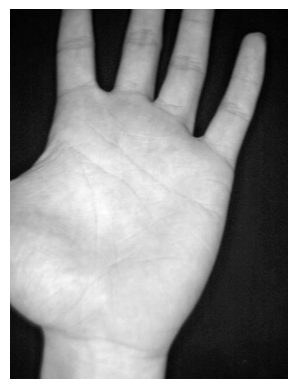

In [4]:
# 读取图像
path = '../dataset/CASIA/original/0001/0001_m_l_01.jpg'
# path = '../dataset/tongji/original/session1/00184.tiff'
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
hand_type = path.split('/')[-1].split('_')[2]
print(image.shape)

plt.axis('off')
plt.imshow(image, cmap="gray")

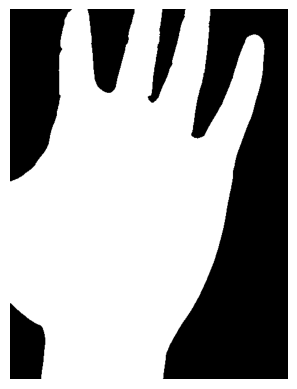

In [5]:
# 纯绘图
blur_image = cv2.GaussianBlur(image, (5, 5), 0)
_, binary_image = cv2.threshold(blur_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.axis('off')
plt.imshow(binary_image, cmap="gray")

"\nfor point in points:\n    plt.plot(point[0], point[1], 'rx')\n    plt.text(point[0], point[1], '(%d, %d)' % (point[0], point[1]), color='r')\n"

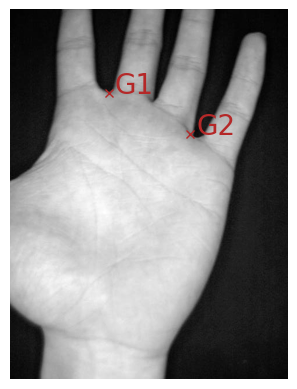

In [9]:
# 获取手指间隙的坐标
contours, pointG1, pointG2 = gap_point(image)

plt.axis('off')
plt.imshow(image, cmap='gray')
plt.plot(pointG1['x'], pointG1['y'], 'x', color=COLORS[1])
plt.text(pointG1['x'] + 10, pointG1['y'], 'G1', color=COLORS[1], size=20)
plt.plot(pointG2['x'], pointG2['y'], 'x', color=COLORS[1])
plt.text(pointG2['x'] + 10, pointG2['y'], 'G2', color=COLORS[1], size=20)

'''
for point in points:
    plt.plot(point[0], point[1], 'rx')
    plt.text(point[0], point[1], '(%d, %d)' % (point[0], point[1]), color='r')
'''

Text(208.9, 265.09999999999997, 'L')

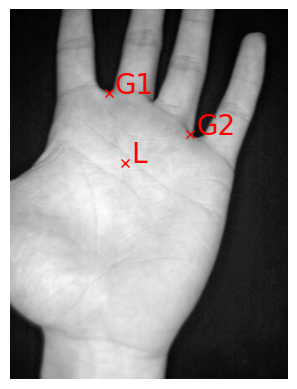

In [7]:
# 建立坐标系
_, x_slope, y_slope, pointL = coordinate_system(pointG1, pointG2)

plt.axis('off')
plt.imshow(image, cmap='gray')
plt.plot(pointG1['x'], pointG1['y'], 'rx')
plt.text(pointG1['x'] + 10, pointG1['y'], 'G1', color='r', size=20)
plt.plot(pointG2['x'], pointG2['y'], 'rx')
plt.text(pointG2['x'] + 10, pointG2['y'], 'G2', color='r', size=20)
plt.plot(pointL['x'], pointL['y'], 'rx')
plt.text(pointL['x'] + 10, pointL['y'], 'L', color='r', size=20)

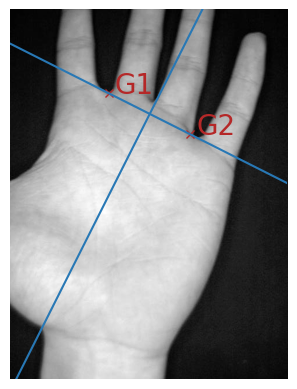

In [11]:
# 纯绘图
plt.axis('off')
plt.imshow(image, cmap='gray')
plt.plot(pointG1['x'], pointG1['y'], 'x', color=COLORS[1])
plt.text(pointG1['x'] + 10, pointG1['y'], 'G1', color=COLORS[1], size=20)
plt.plot(pointG2['x'], pointG2['y'], 'x', color=COLORS[1])
plt.text(pointG2['x'] + 10, pointG2['y'], 'G2', color=COLORS[1], size=20)

# 横轴
slope = (pointG2['y'] - pointG1['y']) / (pointG2['x'] - pointG1['x'])
x_values = range(0, 480)
y_values = [(slope * (x - pointG1['x']) + pointG1['y']) for x in x_values]
plt.plot(x_values, y_values, color=COLORS[0])
# 纵轴
y_values = range(0, 640)
x_values = [(-slope * (y - pointL['y']) + pointL['x']) for y in y_values]
plt.plot(x_values, y_values, color=COLORS[0])

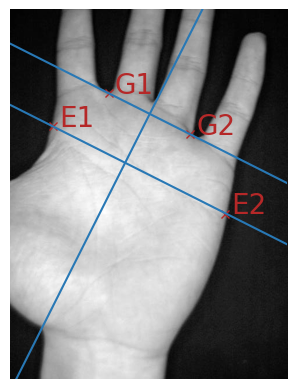

In [12]:
# 获取手掌边缘的坐标
pointE1, pointE2 = edge_point(contours, pointL, x_slope, hand_type)

plt.axis('off')
plt.imshow(image, cmap='gray')
plt.plot(pointG1['x'], pointG1['y'], 'x', color=COLORS[1])
plt.text(pointG1['x'] + 10, pointG1['y'], 'G1', color=COLORS[1], size=20)
plt.plot(pointG2['x'], pointG2['y'], 'x', color=COLORS[1])
plt.text(pointG2['x'] + 10, pointG2['y'], 'G2', color=COLORS[1], size=20)
# plt.plot(pointL['x'], pointL['y'], 'rx')
# plt.text(pointL['x'] + 10, pointL['y'], 'L', color='r', size=20)
plt.plot(pointE1['x'], pointE1['y'], 'x', color=COLORS[1])
plt.text(pointE1['x'] + 10, pointE1['y'], 'E1', color=COLORS[1], size=20)
plt.plot(pointE2['x'], pointE2['y'], 'x', color=COLORS[1])
plt.text(pointE2['x'] + 10, pointE2['y'], 'E2', color=COLORS[1], size=20)

# 横轴
slope = (pointG2['y'] - pointG1['y']) / (pointG2['x'] - pointG1['x'])
x_values = range(0, 480)
y_values = [(slope * (x - pointG1['x']) + pointG1['y']) for x in x_values]
plt.plot(x_values, y_values, color=COLORS[0])
# 纵轴
y_values = range(0, 640)
x_values = [(-slope * (y - pointL['y']) + pointL['x']) for y in y_values]
plt.plot(x_values, y_values, color=COLORS[0])
# 直线 l
slope = (pointG2['y'] - pointG1['y']) / (pointG2['x'] - pointG1['x'])
x_values = range(0, 480)
y_values = [(slope * (x - pointL['x']) + pointL['y']) for x in x_values]
plt.plot(x_values, y_values, color=COLORS[0])

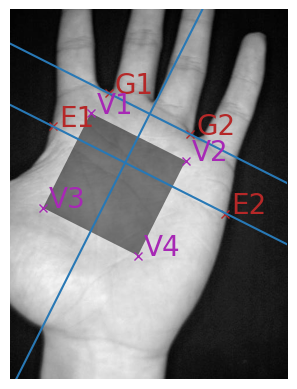

In [15]:
# 获取 ROI 顶点的坐标
pointV1, pointV2, pointV3, pointV4 = roi_vertex(pointL, pointE1, pointE2, x_slope, y_slope)

plt.axis('off')
plt.imshow(image, cmap='gray')
plt.plot(pointG1['x'], pointG1['y'], 'x', color=COLORS[1])
plt.text(pointG1['x'] + 10, pointG1['y'], 'G1', color=COLORS[1], size=20)
plt.plot(pointG2['x'], pointG2['y'], 'x', color=COLORS[1])
plt.text(pointG2['x'] + 10, pointG2['y'], 'G2', color=COLORS[1], size=20)
# plt.plot(pointL['x'], pointL['y'], 'rx')
# plt.text(pointL['x'] + 10, pointL['y'], 'L', color='r', size=20)
plt.plot(pointE1['x'], pointE1['y'], 'x', color=COLORS[1])
plt.text(pointE1['x'] + 10, pointE1['y'], 'E1', color=COLORS[1], size=20)
plt.plot(pointE2['x'], pointE2['y'], 'x', color=COLORS[1])
plt.text(pointE2['x'] + 10, pointE2['y'], 'E2', color=COLORS[1], size=20)
plt.plot(pointV1['x'], pointV1['y'], 'x', color=COLORS[2])
plt.text(pointV1['x'] + 10, pointV1['y'], 'V1', color=COLORS[2], size=20)
plt.plot(pointV2['x'], pointV2['y'], 'x', color=COLORS[2])
plt.text(pointV2['x'] + 10, pointV2['y'], 'V2', color=COLORS[2], size=20)
plt.plot(pointV3['x'], pointV3['y'], 'x', color=COLORS[2])
plt.text(pointV3['x'] + 10, pointV3['y'], 'V3', color=COLORS[2], size=20)
plt.plot(pointV4['x'], pointV4['y'], 'x', color=COLORS[2])
plt.text(pointV4['x'] + 10, pointV4['y'], 'V4', color=COLORS[2], size=20)

# 横轴
slope = (pointG2['y'] - pointG1['y']) / (pointG2['x'] - pointG1['x'])
x_values = range(0, 480)
y_values = [(slope * (x - pointG1['x']) + pointG1['y']) for x in x_values]
plt.plot(x_values, y_values, color=COLORS[0])
# 纵轴
y_values = range(0, 640)
x_values = [(-slope * (y - pointL['y']) + pointL['x']) for y in y_values]
plt.plot(x_values, y_values, color=COLORS[0])
# 直线 l
slope = (pointG2['y'] - pointG1['y']) / (pointG2['x'] - pointG1['x'])
x_values = range(0, 480)
y_values = [(slope * (x - pointL['x']) + pointL['y']) for x in x_values]
plt.plot(x_values, y_values, color=COLORS[0])

x_list = [pointV1['x'], pointV2['x'], pointV4['x'], pointV3['x']]
y_list = [pointV1['y'], pointV2['y'], pointV4['y'], pointV3['y']]
plt.fill(x_list, y_list, 'black', alpha=0.5)

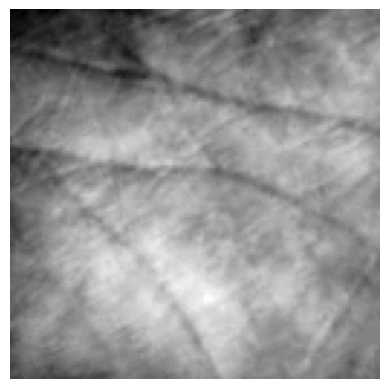

In [35]:
# 保存图像
points = np.array([(pointV1['x'], pointV1['y']), (pointV2['x'], pointV2['y']), (pointV3['x'], pointV3['y']), (pointV4['x'], pointV4['y'])], dtype=np.float32)
rotated_box = cv2.minAreaRect(points)  # 求最小外接矩形, 即 ROI
center, size, angle = rotated_box[0], rotated_box[1], rotated_box[2]  # 返回中心点, 宽和高, 旋转角度; 旋转角度是 x 轴逆时针旋转第一次碰到举行的边时的角度
center, size = tuple(map(int, center)), tuple(map(int, size))
angle = math.degrees(math.atan(x_slope))  # 重新计算角度
height, width = image.shape[0], image.shape[1]
mu = cv2.getRotationMatrix2D(center, angle, 1)  # 将原图绕 ROI 中心点旋转
rotate_image = cv2.warpAffine(image, mu, (width, height))
crop_image = cv2.getRectSubPix(rotate_image, size, center)  # 裁剪 ROI
resize_image = cv2.resize(crop_image, (N, N))  # 压缩大小

plt.axis('off')
plt.imshow(resize_image, cmap='gray')